In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
import xesmf as xe
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from matplotlib import gridspec
import time

In [2]:
vert_ds = xr.open_dataarray('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/vert_ds.nc')
vert_ds.load()

<xarray.DataArray 'wap' (lat: 88, lon: 179)>
array([[ 9.05317347e-03,  5.35726221e-03,  3.90954921e-03, ...,
         1.37608778e-02,  1.27784014e-02,  1.16651980e-02],
       [ 1.62603296e-02,  1.84076093e-02,  1.68463495e-02, ...,
         2.34749150e-02,  2.32172329e-02,  2.24996507e-02],
       [ 1.72343142e-02,  1.73817184e-02,  1.67526975e-02, ...,
         1.50780585e-02,  1.46754114e-02,  1.46230198e-02],
       ...,
       [-2.22924957e-03, -1.80104235e-03, -1.62051118e-03, ...,
        -1.75005000e-03, -2.10483326e-03, -2.04990618e-03],
       [-6.93217677e-04, -1.27934688e-03, -1.30213355e-03, ...,
        -7.43095938e-04, -8.93206510e-04, -9.83634265e-04],
       [ 4.50923544e-04, -8.85086847e-05,  6.49775393e-05, ...,
        -5.63950336e-04, -4.56162205e-04, -3.77876189e-04]], dtype=float32)
Coordinates:
    plev     float64 5e+04
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [3]:
# Head to google catalog to get some vertical motion data

# Read in data catalog

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


# SST - piControl

In [16]:
# Find SST

df_sst_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl'")
df_sst_control = df_sst_control.drop_duplicates('source_id').head(23)
df_sst_control = df_sst_control.drop(index=44330)
df_sst_control = df_sst_control.drop(index=55630)
df_sst_control = df_sst_control.drop(index=67594)
df_sst_control = df_sst_control.drop(index=67702)
#df_sst_control = df_sst_control.drop(index=246458)
#df_sst_control = df_sst_control.drop(index=253865)
#df_sst_control = df_sst_control.drop(index=375351)
#df_sst_control = df_sst_control.drop(index=385525)
#df_sst_control = df_sst_control.drop(index=416429)
df_sst_control = df_sst_control.drop(index=75733)
df_sst_control = df_sst_control.drop(index=206179)
df_sst_control = df_sst_control.drop(index=209012)
df_sst_control = df_sst_control.drop(index=217984)
df_sst_control = df_sst_control.drop(index=236032)
df_sst_control = df_sst_control.drop(index=237883)
df_sst_control = df_sst_control.drop(index=66921)
df_sst_control

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9418,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Amon,ts,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...,NaN,20180701
18366,CMIP,NOAA-GFDL,GFDL-ESM4,piControl,r1i1p1f1,Amon,ts,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...,NaN,20180701
31900,CMIP,CNRM-CERFACS,CNRM-CM6-1,piControl,r1i1p1f2,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180814
32184,CMIP,NASA-GISS,GISS-E2-1-G,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...,NaN,20180824
40419,CMIP,BCC,BCC-CSM2-MR,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...,NaN,20181016
42780,CMIP,CNRM-CERFACS,CNRM-ESM2-1,piControl,r1i1p1f2,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181115
44600,CMIP,BCC,BCC-ESM1,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...,NaN,20181214
87889,CMIP,CCCma,CanESM5-CanOE,piControl,r1i1p2f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...,NaN,20190429
90064,CMIP,CCCma,CanESM5,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...,NaN,20190429
211884,CMIP,HAMMOZ-Consortium,MPI-ESM-1-2-HAM,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...,NaN,20190627


#### Load MIROC6

In [17]:
df_sst_miroc6 = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl' & source_id == 'MIROC6'")
df_sst_miroc6

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
44330,CMIP,MIROC,MIROC6,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...,NaN,20181212


#### Add FGOALS-g3

In [8]:
df_sst_fgoals = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'")
df_sst_fgoals

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
254979,CMIP,CAS,FGOALS-g3,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...,NaN,20190818


#### Add IPSL dataset

In [18]:
df_sst_ipsl = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl' & source_id == 'IPSL-CM6A-LR' & member_id=='r1i1p1f1'")
df_sst_ipsl

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
429109,CMIP,IPSL,IPSL-CM6A-LR,piControl,r1i1p1f1,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...,NaN,20200326


In [19]:
df_sst_control = df_sst_control.append(df_sst_miroc6)
df_sst_control = df_sst_control.append(df_sst_fgoals)
df_sst_control = df_sst_control.append(df_sst_ipsl)
df_sst_control

/tmp/ipykernel_4987/2793282092.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sst_control = df_sst_control.append(df_sst_miroc6)
/tmp/ipykernel_4987/2793282092.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sst_control = df_sst_control.append(df_sst_fgoals)
/tmp/ipykernel_4987/2793282092.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sst_control = df_sst_control.append(df_sst_ipsl)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9418,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Amon,ts,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...,NaN,20180701
18366,CMIP,NOAA-GFDL,GFDL-ESM4,piControl,r1i1p1f1,Amon,ts,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...,NaN,20180701
31900,CMIP,CNRM-CERFACS,CNRM-CM6-1,piControl,r1i1p1f2,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180814
32184,CMIP,NASA-GISS,GISS-E2-1-G,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...,NaN,20180824
40419,CMIP,BCC,BCC-CSM2-MR,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...,NaN,20181016
42780,CMIP,CNRM-CERFACS,CNRM-ESM2-1,piControl,r1i1p1f2,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181115
44600,CMIP,BCC,BCC-ESM1,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...,NaN,20181214
87889,CMIP,CCCma,CanESM5-CanOE,piControl,r1i1p2f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...,NaN,20190429
90064,CMIP,CCCma,CanESM5,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...,NaN,20190429
211884,CMIP,HAMMOZ-Consortium,MPI-ESM-1-2-HAM,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...,NaN,20190627


In [25]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_sst = []
for zstore in df_sst_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds_sel = ds.isel(time=slice(300,3300))
    ds_surface_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_sst = ds_surface_interp.ts
    ds_sst['name'] = name # Creating a new dimension for each ensemble member
    dset_list_sst.append(ds_sst)

GFDL-CM4
GFDL-ESM4
CNRM-CM6-1


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


GISS-E2-1-G
BCC-CSM2-MR
CNRM-ESM2-1
BCC-ESM1
CanESM5-CanOE
CanESM5
MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

HadGEM3-GC31-LL
E3SM-1-0
MIROC6


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

FGOALS-g3
IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [26]:
SST_control = xr.concat(dset_list_sst, dim='name', coords='minimal', compat='override')
SST_control.load()

<xarray.DataArray 'ts' (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[243.18496246, 243.0430336 , 242.90864563, ..., 243.75744705,
          243.6136322 , 243.47025681],
         [243.91621094, 243.58426437, 243.37599564, ..., 245.18914566,
          244.86694336, 244.54597549],
         [245.59149551, 245.1326683 , 244.65911102, ..., 247.68568878,
          247.14878464, 246.61694489],
         ...,
         [239.55025787, 239.92131195, 240.25101852, ..., 237.72741852,
          237.87510681, 238.06498566],
         [238.32813339, 238.6320961 , 238.78931427, ..., 237.56899948,
          237.70903015, 237.84785614],
         [236.66961594, 236.70400772, 236.74081421, ..., 236.53036346,
          236.56542206, 236.60032578]],

        [[231.3177597 , 231.15438766, 231.01077652, ..., 231.97694626,
          231.81131363, 231.64621048],
         [232.09978867, 231.65678024, 231.46744919, ..., 233.87158051,
          233.43950653, 233.00966873],
         [234.51739807, 234.01972885, 233.50682068, ..., 237.02090225,
          236.37061691, 235.73139725],
...
         [252.6314019 , 253.00705589, 253.27285173, ..., 250.59691569,
          251.33007984, 251.73059956],
         [250.57741261, 250.86533582, 251.07462841, ..., 249.44685013,
          249.71823049, 249.99883515],
         [249.48820074, 249.57583261, 249.61054581, ..., 249.09102365,
          249.2286624 , 249.33934194]],

        [[245.89039754, 245.79137869, 245.69797414, ..., 246.28718255,
          246.18609571, 246.08100414],
         [246.221572  , 246.11203082, 246.03149157, ..., 246.92299288,
          246.67959114, 246.49861298],
         [247.77117087, 247.41665991, 247.12117474, ..., 249.08780638,
          248.75362614, 248.43839637],
         ...,
         [247.44068585, 247.76085688, 248.02600625, ..., 245.28867583,
          245.93020479, 246.44387522],
         [245.94969518, 246.23730513, 246.43921414, ..., 244.95586261,
          245.21822464, 245.41741683],
         [245.20291891, 245.41547107, 245.56769846, ..., 244.54256509,
          244.69713293, 244.88479369]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'GFDL-CM4' 'GFDL-ESM4' ... 'FGOALS-g3' 'IPSL-CM6A-LR'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Surface Temperature
    original_name:  ts
    standard_name:  surface_temperature
    units:          K

In [61]:
SST_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_ts_piControl_2x2_250yr.nc')

Text(0.5, 0.99, 'Mean TS')

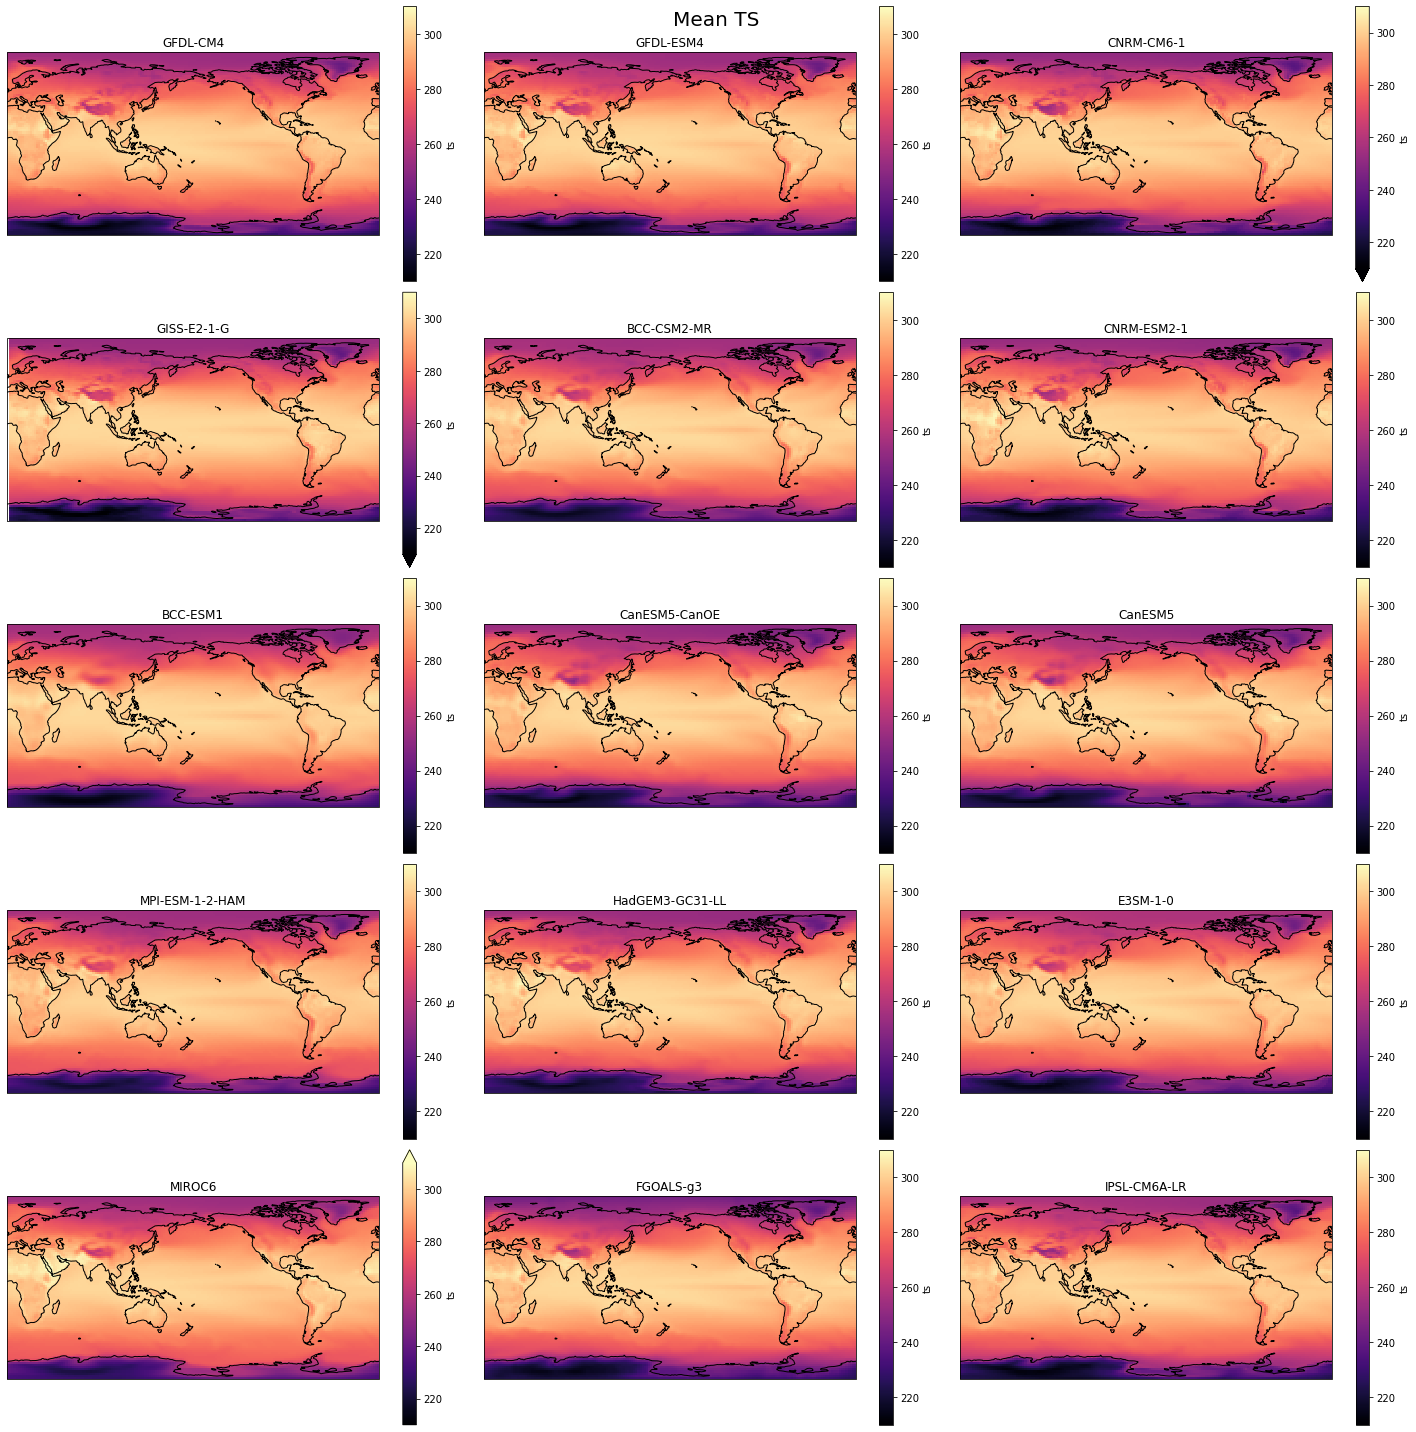

In [57]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in SST_control['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    SST_control.sel(name=model).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=210, vmax=310, cmap='magma')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('Mean TS', fontsize=20, y=0.99)

Text(0.5, 0.99, 'TS Interdecadal Variability')

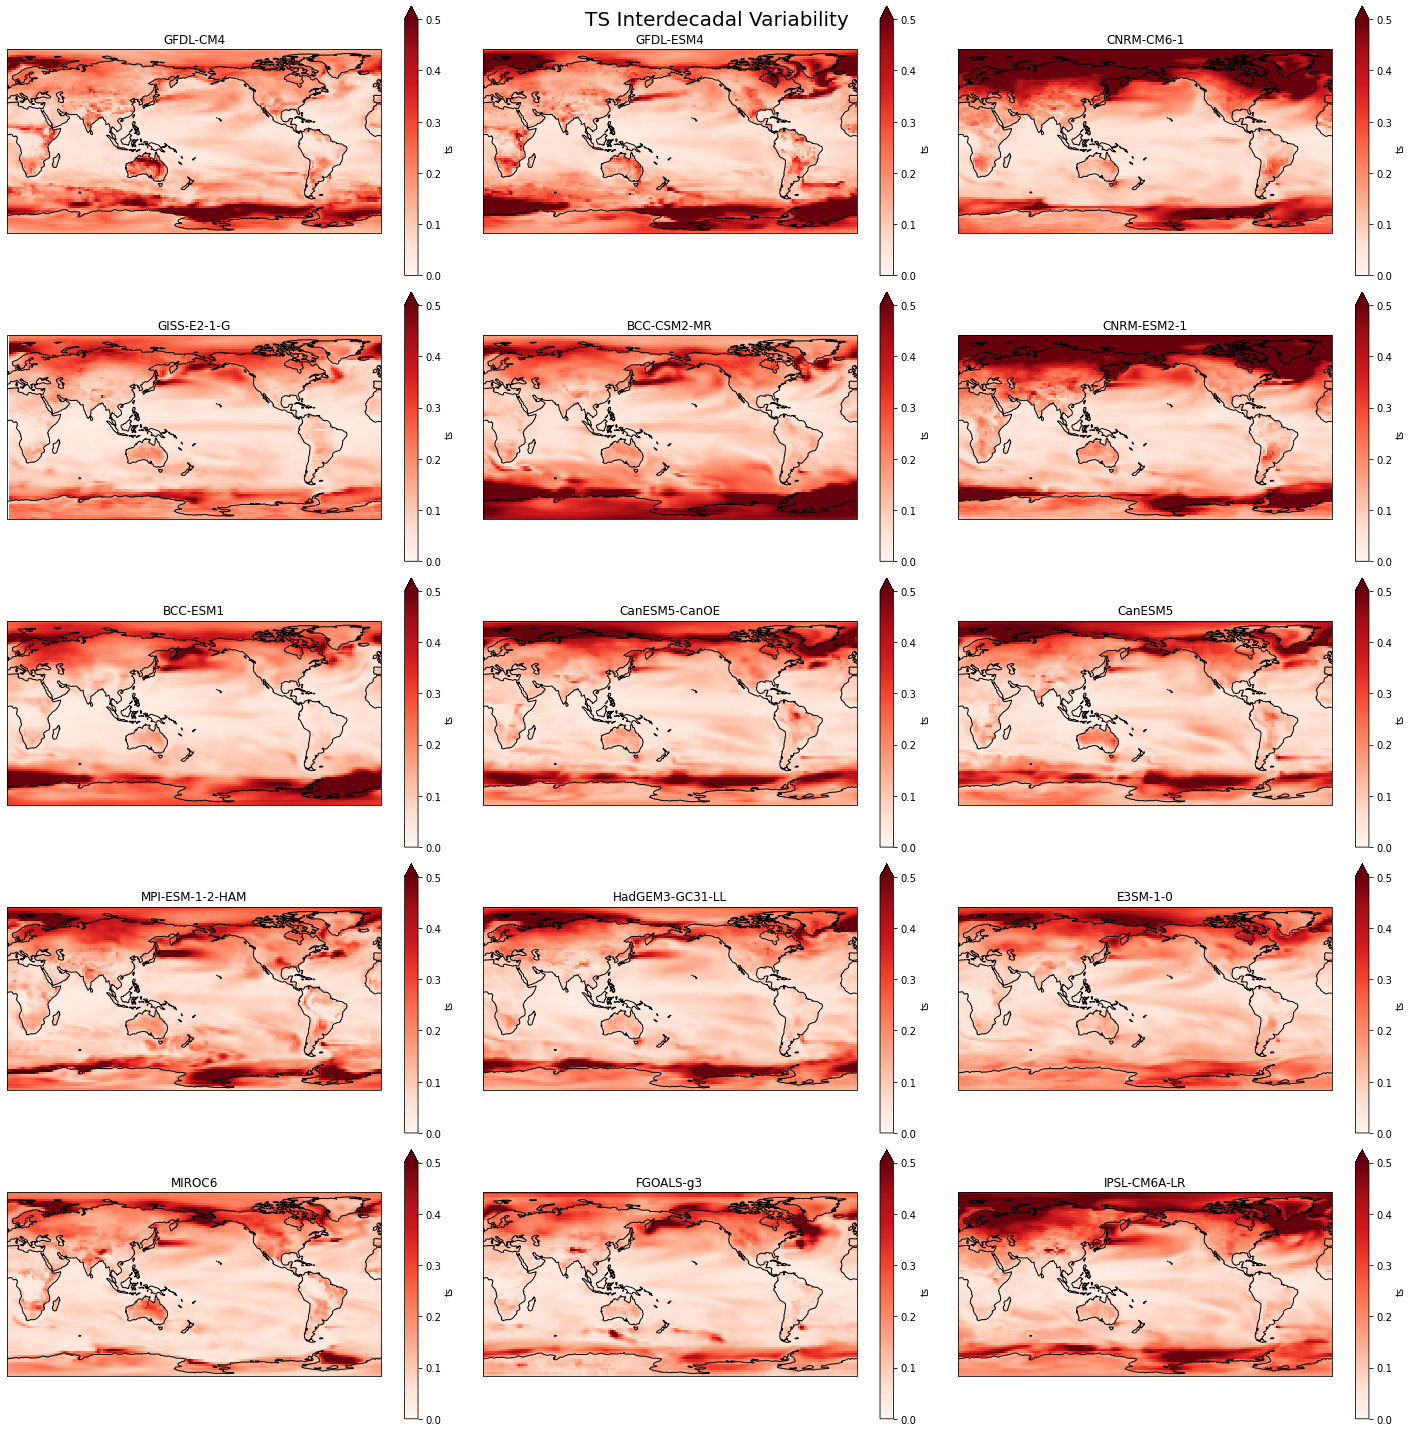

In [58]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in SST_control['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    rolling = SST_control.sel(name=model).rolling(time=300, center=True).mean('time')
    rolling.std('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=0.5, cmap='Reds')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('TS Interdecadal Variability', fontsize=20, y=0.99)

In [44]:
SST_rolling = SST_control.rolling(time=300, center=True).mean('time')
SST_stand = SST_rolling.std('time')
SST_var = SST_stand.mean('name')

Text(0.5, 1.0, '25 year TS interdecadal variability (N=15)')

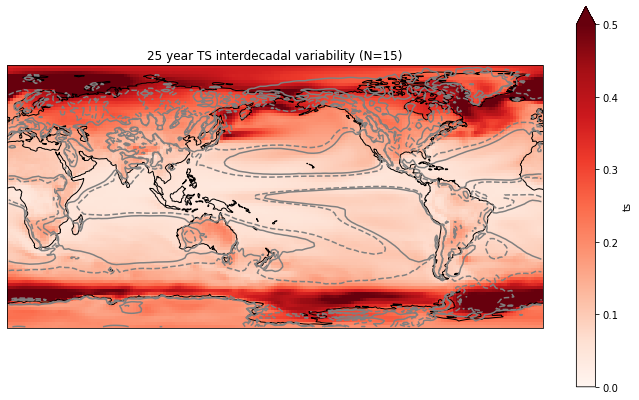

In [60]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
SST_var.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=0.5, cmap='Reds')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('25 year TS interdecadal variability (N=15)')

# MLOTST Control

In [44]:
def nc_varget(fin,vin):
    """
    Extract dataset elements
    """
    with fin as f:
        return f.variables[vin][:]

def mlotst_load(dataset):
    # From Ryan Abernathy's tutorial - Way 2
    # Regridding advice: https://stackoverflow.com/questions/71616481/converting-from-2d-lat-lon-matrix-into-1d-lat-lon-array
    gcs = gcsfs.GCSFileSystem(token='anon')
    fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

    #time index to assign model times to
    new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years

    # Regridding
    curvi_grid = xe.util.grid_global(2,2, lon1=360)
    new_lats=np.arange(-87,88,2)
    new_lons=np.arange(1,359,2)
    
    zst = dataset.zstore.unique()[0]
    name = zst.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zst), consolidated=True)
    ds = rename_cmip6(ds)
    ds = ds.isel(time=slice(300,3300))
    ds_var = ds.assign(time=new_time_index)
    ds_var = ds_var.mlotst
    if 'lat' in ds.coords:
        regridder = xe.Regridder(ds_var, curvi_grid, "bilinear", ignore_degenerate=True)
        ds_rectilinear = regridder(ds_var)
        fin = ds_rectilinear.to_dataset(name='mlotst') #Name of variable - mlotst
        xin = nc_varget(fin,'lon');
        yin = nc_varget(fin,'lat');
        zin = nc_varget(fin,'mlotst');

        x0,x1,dx = np.min(xin),np.max(xin),np.abs(np.mean(np.diff(xin)))
        y0,y1,dy = np.min(yin),np.max(yin),np.abs(np.mean(np.diff(yin.T)))

        #new coordinates
        xout = np.arange(x0,x1+dx,dx)
        yout = np.arange(y0,y1+dx,dy)

        xm,ym = np.meshgrid(xout,yout)
        zout = np.zeros((3000,90,180))
        start = time.time()
        for t in range(len(ds_var['time'].values)):
            zo = griddata((xin.values.flatten(),yin.values.flatten()),zin.isel(time=t).values.flatten(),(xm,ym), 'nearest')
            print(zo)
            print(zo.shape)
            zout[t,:,:] = zo
            if t%100==0:
                print(t)
                print(time.time() - start)
                print(time.asctime())
                start = time.time()

        ds_regrid = xr.DataArray(zout, dims=['time','lat','lon'])
        ds_regrid.coords['lon'] = xout
        ds_regrid.coords['lat'] = yout
        ds_regrid.coords['time'] = new_time_index
        ds_interp = ds_regrid.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        print(name, 'processed')
        print(ds_interp)
        return ds_interp
    else:
        ds_var = ds_var.rename({'x':'lon', 'y':'lat'})
        ds_interp = ds_var.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        print(name, 'processed')
        print(ds_interp)
        return ds_interp


In [143]:
def nc_varget(fin,vin):
    """
    Extract dataset elements
    """
    with fin as f:
        return f.variables[vin][:]

def interp_griddata(xin, yin, zin, xm, ym):
    print(f"data: {zin.shape}| xin: {xin.shape} | yin: {yin.shape} | xm: {xm.shape} | ym: {ym.shape}")
    return griddata((xin,yin),zin.flatten(),(xm,ym), 'nearest')

def mlotst_load_ufunc(dataset):
    # From Ryan Abernathy's tutorial - Way 2
    # Regridding advice: https://stackoverflow.com/questions/71616481/converting-from-2d-lat-lon-matrix-into-1d-lat-lon-array
    gcs = gcsfs.GCSFileSystem(token='anon')
    fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

    #time index to assign model times to
    new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years

    # Regridding
    curvi_grid = xe.util.grid_global(2,2, lon1=360)
    new_lats=np.arange(-87,88,2)
    new_lons=np.arange(1,359,2)
    
    zst = dataset.zstore.unique()[0]
    name = zst.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zst), consolidated=True)
    ds = rename_cmip6(ds)
    ds = ds.isel(time=slice(300,3300))
    ds_var = ds.assign(time=new_time_index)
    ds_var = ds_var.mlotst
    if 'lat' in ds.coords:
        regridder = xe.Regridder(ds_var, curvi_grid, "bilinear", ignore_degenerate=True)
        ds_rectilinear = regridder(ds_var)
        fin = ds_rectilinear.to_dataset(name='mlotst') #Name of variable - mlotst
        xin = nc_varget(fin,'lon');
        yin = nc_varget(fin,'lat');
        zin = nc_varget(fin,'mlotst');

        x0,x1,dx = np.min(xin),np.max(xin),np.abs(np.mean(np.diff(xin)))
        y0,y1,dy = np.min(yin),np.max(yin),np.abs(np.mean(np.diff(yin.T)))

        #new coordinates
        xout = np.arange(x0,x1+dx,dx)
        yout = np.arange(y0,y1+dx,dy)

        xm,ym = np.meshgrid(xout,yout)
        #zout = np.zeros((3000,90,180))
        xin = xr.DataArray(xin.values.flatten(), dims=['xin'])
        yin = xr.DataArray(yin.values.flatten(), dims=['yin'])
        xm = xr.DataArray(xm, dims=['xm1', 'xm2'])
        ym = xr.DataArray(ym, dims=['ym1', 'ym2'])
        zin = xr.DataArray(zin, dims=['time', 'y', 'x'])
        zout = xr.apply_ufunc(interp_griddata, xin, yin, zin, xm, ym, 
                              input_core_dims=[["xin"],["yin"],["y","x"],["xm1","xm2"],["ym1","ym2"]], 
                              output_core_dims=["lon", "lat"], #output_sizes={"lon":180, "lat":90},
                              exclude_dims=set(("x", "y")), dask='allowed', vectorize=True)
        print(zout.shape)
        ds_regrid = xr.DataArray(zout, dims=['time','lat','lon'])
        ds_regrid.coords['lon'] = xout
        ds_regrid.coords['lat'] = yout
        ds_regrid.coords['time'] = new_time_index
        ds_interp = ds_regrid.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        print(name, 'processed')
        print(ds_interp)
        return ds_interp
    else:
        ds_var = ds_var.rename({'x':'lon', 'y':'lat'})
        ds_interp = ds_var.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        print(name, 'processed')
        print(ds_interp)
        return ds_interp


In [24]:
df_hml_HadGEM3 = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'HadGEM3-GC31-LL'").head(1)
df_hml_HadGEM3

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
523689,CMIP,MOHC,HadGEM3-GC31-LL,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...,NaN,20211103


In [82]:
mlotst_HadGEM3 = mlotst_load(df_hml_HadGEM3)

HadGEM3-GC31-LL
[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 ...
 [31.685074 31.732697 31.763855 ... 31.469658 31.540918 31.618298]
 [34.026123 34.091652 34.137547 ... 33.868713 33.91246  33.966297]
 [34.5405   34.5184   34.49644  ... 34.596363 34.580074 34.56269 ]]
(90, 180)
0
2.050370454788208
Fri Feb 16 16:02:53 2024
[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 ...
 [33.600945 33.483673 33.347736 ... 33.214714 33.30589  33.452053]
 [38.195496 38.287663 38.358715 ... 38.024586 38.072224 38.12417 ]
 [38.750675 38.70625  38.663307 ... 39.063576 38.92825  38.796246]]
(90, 180)
[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ... 

KeyboardInterrupt: 

In [144]:
mlotst_HadGEM3 = mlotst_load_ufunc(df_hml_HadGEM3)

HadGEM3-GC31-LL
('time', 'y', 'x')
('xin',)
('yin',)
('xm1', 'xm2')
('ym1', 'ym2')
<class 'xarray.core.dataarray.DataArray'>
data: (3000, 90, 180)| xin: (16200,) | yin: (16200,) | xm: (90, 180) | ym: (90, 180)


ValueError: different number of values and points

In [9]:
df_hml_CanESM5 = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'CanESM5'").head(1)
df_hml_CanESM5

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
89859,CMIP,CCCma,CanESM5,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...,NaN,20190429


In [10]:
mlotst_CanESM5 = mlotst_load(df_hml_CanESM5)

CanESM5
0
1.8408477306365967
100
169.06309914588928
200
165.47023725509644


KeyboardInterrupt: 

In [12]:
df_hml_CanESM5_CanOE = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'CanESM5-CanOE'").head(1)
df_hml_CanESM5_CanOE

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
87841,CMIP,CCCma,CanESM5-CanOE,piControl,r1i1p2f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...,NaN,20190429


In [18]:
mlotst_CanESM5CanOE = mlotst_load(df_hml_CanESM5_CanOE)

CanESM5-CanOE
0
1.3539164066314697
Fri Feb 16 12:34:00 2024
100
135.97357606887817
Fri Feb 16 12:36:16 2024
200
146.4726014137268
Fri Feb 16 12:38:43 2024
300
153.87383389472961
Fri Feb 16 12:41:17 2024
400
151.3892207145691
Fri Feb 16 12:43:48 2024
500
147.74276328086853
Fri Feb 16 12:46:16 2024
600
147.48832488059998
Fri Feb 16 12:48:43 2024
700
158.78360867500305
Fri Feb 16 12:51:22 2024
800
147.66990518569946
Fri Feb 16 12:53:50 2024
900
145.8843138217926
Fri Feb 16 12:56:16 2024
1000
146.54380702972412
Fri Feb 16 12:58:42 2024


KeyboardInterrupt: 

In [19]:
df_hml_MPIESM = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'MPI-ESM-1-2-HAM'").head(1)
df_hml_MPIESM

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
407439,CMIP,HAMMOZ-Consortium,MPI-ESM-1-2-HAM,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...,NaN,20200120


In [20]:
mlotst_MPIESM = mlotst_load(df_hml_MPIESM)

MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

0
1.48968505859375
Fri Feb 16 13:15:04 2024
100
145.281729221344
Fri Feb 16 13:17:29 2024
200
151.55665683746338
Fri Feb 16 13:20:01 2024
300
153.78099012374878
Fri Feb 16 13:22:35 2024
400
149.3816635608673
Fri Feb 16 13:25:04 2024
500
151.96815037727356
Fri Feb 16 13:27:36 2024
600
151.66523432731628
Fri Feb 16 13:30:08 2024
700
152.73396253585815
Fri Feb 16 13:32:41 2024
800
154.56658029556274
Fri Feb 16 13:35:15 2024
900
160.41902995109558
Fri Feb 16 13:37:56 2024
1000
165.4810254573822
Fri Feb 16 13:40:41 2024
1100
167.54537868499756
Fri Feb 16 13:43:29 2024
1200
167.93363523483276
Fri Feb 16 13:46:16 2024
1300
167.2089729309082
Fri Feb 16 13:49:04 2024
1400
177.04118871688843
Fri Feb 16 13:52:01 2024
1500
166.35709857940674
Fri Feb 16 13:54:47 2024
1600
182.34733533859253
Fri Feb 16 13:57:49 2024
1700
176.78548955917358
Fri Feb 16 14:00:46 2024
1800
179.36463236808777
Fri Feb 16 14:03:46 2024
1900
186.1148407459259
Fri Feb 16 14:06:52 2024
2000
181.06188893318176
Fri Feb 16 14:09

In [21]:
mlotst_MPIESM.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_mlotst_MPIESM_250yr.nc')